# Lesson 2 : LangGraph Components

In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
# 这里需要输入Tavily api key，可以到Tavily网站申请

import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var]=getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [3]:
# TavilySearchResults是一个预定义的搜索引擎tool
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [5]:
class Agent:

    # 后面执行abot = Agent(model, [tool], system=prompt)时会调用到__init__方法。
    # 1. 创建graph。
    # 2. 创建节点llm和action。
    # 3. 创建条件边，从llm出发，根据条件函数exists_action的返回值，决定执行哪一条路径，True执行action节点，False执行END。
    # 4. 创建action到llm的边。
    # 5. set_entry_point的作用是“Specifies the first node to be called in the graph. Equivalent to calling `add_edge(START, key)`”
    # 6. 将model和tools绑定。
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    # 检查state中的最后一个消息是否包含工具调用
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [6]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(
    model_name='qwen2',
    #model_name='deepseek-r1:32b',
    openai_api_base="http://127.0.0.1:11434/v1",
    openai_api_key="EMPTY",
    streaming=True
)
abot = Agent(model, [tool], system=prompt)

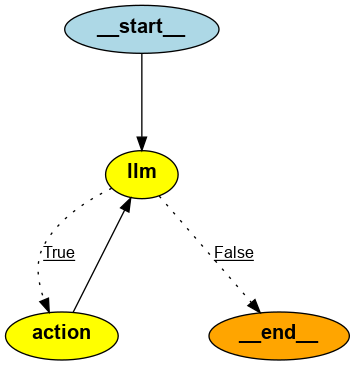

In [7]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [8]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in sf'}, 'id': 'call_idihsyga', 'type': 'tool_call'}
Back to the model!


In [9]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_idihsyga', 'function': {'arguments': '{"query":"current weather in sf"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'qwen2', 'system_fingerprint': 'fp_ollama'}, id='run-79711b72-d77c-468f-9bdc-47ba16486a03-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in sf'}, 'id': 'call_idihsyga', 'type': 'tool_call'}]),
  ToolMessage(content='[{\'title\': \'Weather in san francisco ca\', \'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.775, \'lon\': -122.4183, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1741864084, \'localtime\': \'2025-03

In [10]:
result['messages'][-1].content

'The current weather in San Francisco is as follows: \nTemperature: Around 8.9°C (48°F)\nCondition: Partly cloudy\nWind Speed: 11.4 mph (18.4 km/h)\nHumidity: 80%\nCloud Cover: 75%\n\nAs of today, the conditions seem to be comfortable with a mix of sun and clouds.'

Qwne2直接把2个子问题一起去搜索，GPT分成2个子问题，并行搜索。

In [11]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather condition in SF and LA'}, 'id': 'call_3kei1vd8', 'type': 'tool_call'}
Back to the model!


In [12]:
result['messages'][-1].content

'The current weather conditions in San Francisco, California:\n\n- Temperature: About 16.3°C (61.3°F)\n- Condition: Partly cloudy\n- Wind: \n  - Speed: 2.2 mph (3.6 km/h)\n  - Direction: NE (39 degrees)\n- Humidity: 88%\n- Pressure: 1019.0 mb / 30.09 inHg\n\nThe current weather conditions in Los Angeles, California:\n\n- Temperature: About 65°F\n- Condition: Chance of Rain is currently 0% \n\nCheck the provided links for more detailed information and forecasts.'

Qwen2模型没有把这个复杂的问题分成3个子问题，依次调用Tavily工具搜索，只搜索了第1个子问题。GPT能很好的回答3个子问题。

In [15]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'who won the super bowl in 2024'}, 'id': 'call_2j6shkft', 'type': 'tool_call'}
Back to the model!


In [16]:
print(result['messages'][-1].content)

<root>
  <query_results>
    <query_result score="0.4" title="Super Bowl Winners by Year - ESPN">
      <url>http://www.espn.com/nfl/superbowl/history/winners</url>
      <content>Super Bowl Winners by Year - ESPN NFL History - Super Bowl Winners Leaders Super Bowl Winners Super Bowl MVPs SPORTS NBA College Football Olympic Sports Horse Racing Football ESPN THE MAGAZINE TEAM ESPN ESPN FRONT ROW ESPN NBA More Sports Gaming NBA G League NBA Summer League RN BB RN FB Sports Betting X Games ESPN BET ESPN+ Super Bowl Winners Weekly Leaders ESPN.com: Help | Press | Advertise on ESPN.com | Sales Media Kit | Interest-Based Ads | Do Not Sell or Share My Personal Information | Report a Bug | Corrections | Contact Us | Site Map | Jobs at ESPN © 2025 ESPN Internet Ventures.</content>
    </query_result>
    <query_result score="0.3" title="Super Bowl LVIII - Wikipedia">
      <url>https://en.wikipedia.org/wiki/Super_Bowl_LVIII</url>
      <content>The game was televised nationally by CBS, streamed